In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit
import os
from astropy.timeseries import LombScargle

## CAMPO B278

In [11]:
# Especifica la ruta completa o relativa de tu archivo .dat
archivo_dat = 'datosEpocas.dat'

# Usa pandas para cargar los datos en un DataFrame, utilizando espacio como delimitador
datos_df = pd.read_csv(archivo_dat, delimiter=' ')
# Filtrar las filas donde "campo" es igual a "b278" y "banda" es igual a "Ks"
columna_campo_filtrada = datos_df.loc[(datos_df['campo'] == 'b278') & (datos_df['banda'] == 'Ks')]

# Ordenar el DataFrame según la columna "lineas" de mayor a menor
columna_campo_filtrada_ordenada = columna_campo_filtrada.sort_values(by='lineas', ascending=False)

# Guardar la columna "HJD" como un array
array_HJD = columna_campo_filtrada_ordenada['HJD'].to_numpy()
# Crear un objeto HDU (Header Data Unit) de tipo ImageHDU
hdu = fits.ImageHDU(array_HJD, name='HJD')

# Crear un objeto HDUList que contiene el HDU
hdul = fits.HDUList([fits.PrimaryHDU(), hdu])

# Especificar el nombre del archivo FITS
nombre_archivo = 'Totalcampob278.fits'

# Guardar el archivo FITS
hdul.writeto(nombre_archivo, overwrite=True)

# Imprimir un mensaje de confirmación
print(f"Archivo FITS creado con array_HJD: {nombre_archivo}")

Archivo FITS creado con array_HJD: Totalcampob278.fits


In [4]:
# Especifica la ruta completa o relativa de tu archivo .dat
archivo_dat = 'superTemplateb278.dat'

# Usa pandas para cargar los datos en un DataFrame, utilizando espacio como delimitador
datos_df = pd.read_csv(archivo_dat, delimiter=' ')

# Inicializar un array para almacenar los valores de las columnas que empiezan con 'Ks' para todas las filas
valores_Ks = []

# Iterar sobre las filas del DataFrame
for index, fila in datos_df.iterrows():
    # Filtrar las columnas que empiezan con 'Ks'
    columnas_con_Ks = [columna for columna in fila.index if columna.startswith('Ks')]
    
    # Crear un array con los valores de las columnas que empiezan con 'Ks'
    valores_Ks_fila = fila[columnas_con_Ks].to_numpy()
    
    # Agregar el array de valores al array general
    valores_Ks.append(valores_Ks_fila)

# Convertir el array general a un array de NumPy
valores_Ks = np.array(valores_Ks)
# Especifica el nombre del archivo FITS existente
nombre_archivo_fits = 'campob278.fits'

# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(nombre_archivo_fits, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(valores_Ks, name='Series Ks')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {nombre_archivo_fits}")

Nuevo HDU agregado al archivo FITS: campob278.fits


In [2]:
nombre_archivo1 = fits.open('campob278.fits')
nombre_archivo1.info()

Filename: campob278.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  HJD           1 ImageHDU         7   (66,)   float64   
  2  SERIES KS     1 ImageHDU         8   (66, 1260548)   float64   


In [3]:
series_ks=nombre_archivo1[2].data
# Inicializar un nuevo array para almacenar las medias
medias = np.zeros(series_ks.shape[0])

# Calcular la media de cada array y almacenarla en el nuevo array
for i in range(series_ks.shape[0]):
    medias[i] = np.nanmean(series_ks[i])

print("Medias de cada array sin tener en cuenta los valores NaN:")
print(medias)

C:\Users\camil\AppData\Local\Temp\ipykernel_7064\315417309.py:7: RuntimeWarning: Mean of empty slice
  medias[i] = np.nanmean(series_ks[i])


Medias de cada array sin tener en cuenta los valores NaN:
[16.1535     15.783      15.80228571 ...         nan         nan
         nan]


In [4]:
# Función para calcular la MAD de una fila
def mad(fila):
    # Calcular la mediana de la fila ignorando NaN
    median = np.nanmedian(fila)
    # Calcular las desviaciones absolutas ignorando NaN
    deviations = np.abs(fila - median)
    # Calcular la mediana de las desviaciones absolutas ignorando NaN
    mad_result = np.nanmedian(deviations)
    return mad_result

# Calcular la MAD para cada fila y almacenarla en un nuevo array
mad_results = np.apply_along_axis(mad, 1, series_ks)

print(mad_results)


C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


[0.1075 0.0425 0.065  ...    nan    nan    nan]


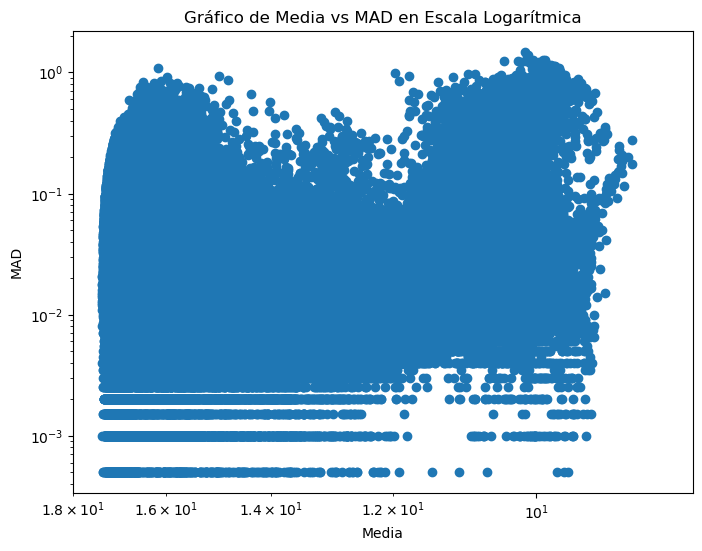

In [5]:
# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(medias, mad_results)
plt.xscale('log')  # Escala logarítmica en el eje x
plt.yscale('log')  # Escala logarítmica en el eje y
plt.xlabel('Media')
plt.ylabel('MAD')
plt.title('Gráfico de Media vs MAD en Escala Logarítmica')
# Invertir el eje x
plt.gca().invert_xaxis()
plt.show()

In [6]:
medias_log = np.log10(medias)
mad_log=np.log10(mad_results)
# Encontrar las posiciones donde medias menor o igual a 12
posiciones_eliminar = [i for i, media_log in enumerate(medias_log) if media_log <= 1.08]

# Eliminar las filas correspondientes de series_ks
series_ks_n = np.delete(series_ks, posiciones_eliminar, axis=0)
medias1= np.delete(medias, posiciones_eliminar, axis=0)
mad_results1 = np.delete(mad_results, posiciones_eliminar, axis=0)

C:\Users\camil\AppData\Local\Temp\ipykernel_7064\2624994973.py:2: RuntimeWarning: divide by zero encountered in log10
  mad_log=np.log10(mad_results)


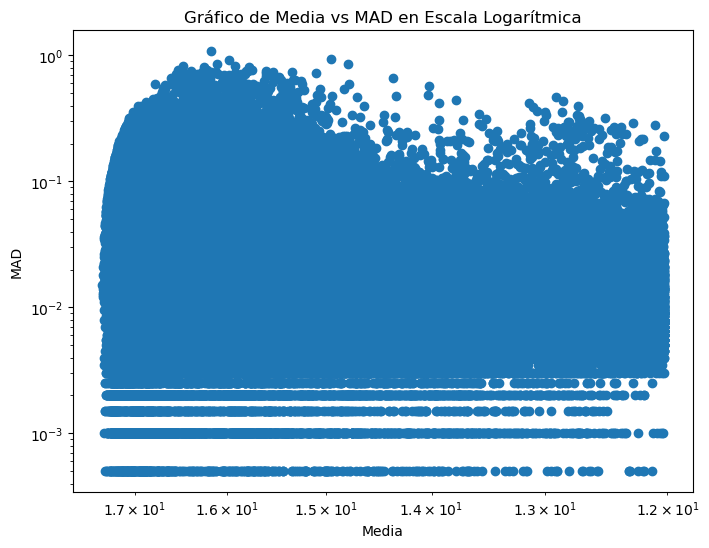

In [7]:
# Graficar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(medias1, mad_results1)
plt.xscale('log')  # Escala logarítmica en el eje x
plt.yscale('log')  # Escala logarítmica en el eje y
plt.xlabel('Media')
plt.ylabel('MAD')
plt.title('Gráfico de Media vs MAD en Escala Logarítmica')
# Invertir el eje x
plt.gca().invert_xaxis()
plt.show()

Cuartil 1: 3.0
Cuartil 2 (mediana): 22.0
Cuartil 3: 54.0


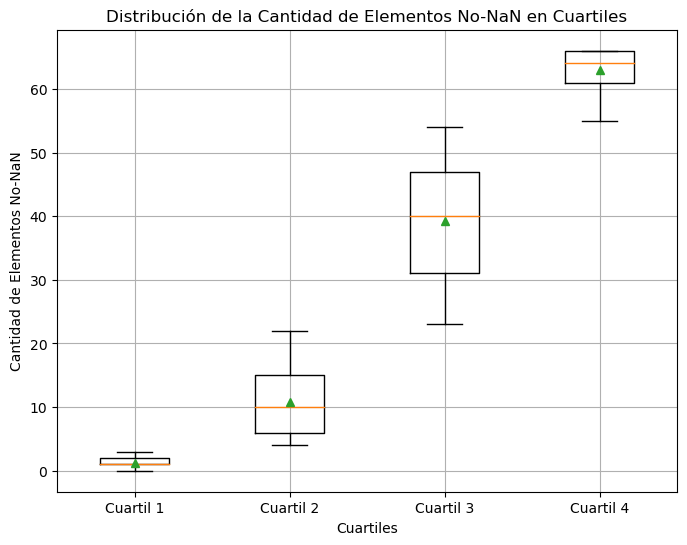

In [8]:
# Calcular la cantidad de elementos no-NaN en cada lista
cantidad_no_nan = np.sum(~np.isnan(series_ks_n), axis=1)

# Calcular los cuartiles
q1 = np.percentile(cantidad_no_nan, 25)
q2 = np.percentile(cantidad_no_nan, 50)
q3 = np.percentile(cantidad_no_nan, 75)

# Imprimir los cuartiles
print("Cuartil 1:", q1)
print("Cuartil 2 (mediana):", q2)
print("Cuartil 3:", q3)

# Dividir las cantidades de elementos no-NaN en cada cuartil
cuartil_1 = cantidad_no_nan[cantidad_no_nan <= q1]
cuartil_2 = cantidad_no_nan[(cantidad_no_nan > q1) & (cantidad_no_nan <= q2)]
cuartil_3 = cantidad_no_nan[(cantidad_no_nan > q2) & (cantidad_no_nan <= q3)]
cuartil_4 = cantidad_no_nan[cantidad_no_nan > q3]

# Realizar box plots para cada cuartil
plt.figure(figsize=(8, 6))
plt.boxplot([cuartil_1, cuartil_2, cuartil_3, cuartil_4], labels=['Cuartil 1', 'Cuartil 2', 'Cuartil 3', 'Cuartil 4'], showmeans=True)
plt.xlabel('Cuartiles')
plt.ylabel('Cantidad de Elementos No-NaN')
plt.title('Distribución de la Cantidad de Elementos No-NaN en Cuartiles')
plt.grid(True)
plt.show()

In [10]:
def eliminar_arrays_cortos(array):
    return [serie for serie in array if np.sum(~np.isnan(serie)) >= 54]
series_ks_n_filtrado = eliminar_arrays_cortos(series_ks_n)
print(series_ks_n_filtrado)
print(len(series_ks_n_filtrado))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
# Especifica el nombre del archivo FITS existente
nombre_archivo_fits = 'Totalcampob278.fits'

# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(nombre_archivo_fits, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(series_ks_n_filtrado, name='Ks')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {nombre_archivo_fits}")

Nuevo HDU agregado al archivo FITS: Totalcampob278.fits


In [8]:
archivo1 = fits.open('Totalcampob278.fits')
archivo1.info()

Filename: Totalcampob278.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  HJD           1 ImageHDU         7   (66,)   float64   
  2  KS            1 ImageHDU         8   (66, 308874)   float64   


In [9]:
serie_ks=archivo1[2].data
def seleccionar_subarrays_aleatorios(serie_ks, cantidad):
    return [random.choice(serie_ks) for _ in range(cantidad)]
cantidad_subarrays = 1000
ks_aleatorios = seleccionar_subarrays_aleatorios(serie_ks, cantidad_subarrays)

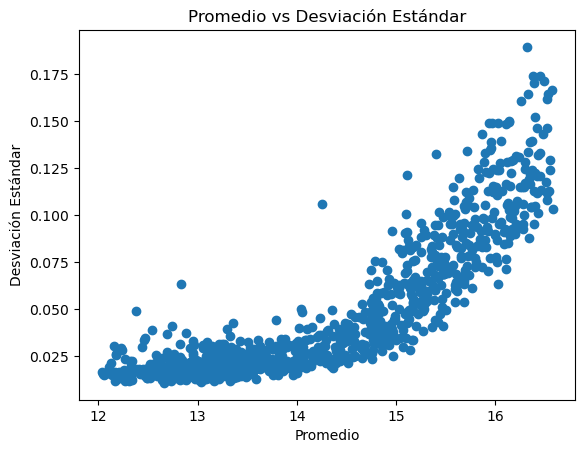

In [10]:
# Función para calcular el promedio excluyendo los NaN
def mean_without_nan(subarray):
    valid_values = [value for value in subarray if not np.isnan(value)]
    return np.mean(valid_values) if valid_values else np.nan

# Función para calcular la desviación estándar excluyendo los NaN
def std_without_nan(subarray):
    valid_values = [value for value in subarray if not np.isnan(value)]
    return np.std(valid_values) if valid_values else np.nan

# Calcula el promedio y la desviación estándar para cada subarray en ks_aleatorios
means = [mean_without_nan(subarray) for subarray in ks_aleatorios]
std_devs = [std_without_nan(subarray) for subarray in ks_aleatorios]

# Grafica la desviación estándar en el eje y y el promedio en el eje x
plt.scatter(means, std_devs)
plt.xlabel('Promedio')
plt.ylabel('Desviación Estándar')
plt.title('Promedio vs Desviación Estándar')
plt.show()

In [6]:
# Definir la función de ajuste
def funcion_ajuste(x, a, b, c):
    return a * x**2 + b * x + c  # Ejemplo de una función cuadrática

# Ajustar la función a los datos
popt, _ = curve_fit(funcion_ajuste, means, std_devs)

# Parámetros óptimos encontrados
a_opt, b_opt, c_opt = popt

# Imprimir la función de ajuste
print(f"Función de ajuste: {a_opt:.2f}x^2 + {b_opt:.2f}x + {c_opt:.2f}")

Función de ajuste: 0.01x^2 + -0.25x + 1.68


In [ ]:
# Plotear los datos y la función de ajuste
plt.scatter(means, std_devs, label='Datos')
x_range = np.linspace(min(means), max(means), 100)
plt.plot(x_range, funcion_ajuste(x_range, *popt+0.04), color='red', label='Función de ajuste')
plt.xlabel('Promedio')
plt.ylabel('Desviación Estándar')
plt.title('Ajuste de función a datos')
plt.legend()
plt.show()

Error in callback <function _draw_all_if_interactive at 0x000001E6B91C2E80> (for post_execute):


In [52]:
# Convertir means a un array de NumPy si no lo es
means = np.array(means)

# Calcular los valores predichos por la función ajustada para todos los elementos de means
predicciones = funcion_ajuste(means, *popt)

# Encontrar las posiciones donde std_devs está por encima de las predicciones
posiciones_por_encima = np.where(std_devs > predicciones)[0]

# Imprimir las posiciones por encima del ajuste
print("Posiciones por encima del ajuste:", posiciones_por_encima)
print(len(posiciones_por_encima))

Posiciones por encima del ajuste: [    0     1     5 ... 99986 99989 99994]
42475


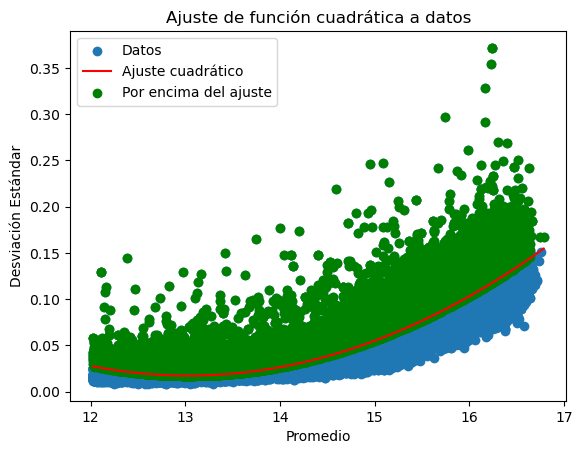

In [50]:
# Convertir means y std_devs a arrays de NumPy si no lo son
means = np.array(means)
std_devs = np.array(std_devs)

# Plotear los datos y la función de ajuste
plt.scatter(means, std_devs, label='Datos')
x_range = np.linspace(min(means), max(means), 100)
plt.plot(x_range, funcion_ajuste(x_range, *popt), color='red', label='Ajuste cuadrático')

# Plotear las posiciones por encima del ajuste cuadrático en otro color
plt.scatter(means[posiciones_por_encima], std_devs[posiciones_por_encima], color='green', label='Por encima del ajuste')

plt.xlabel('Promedio')
plt.ylabel('Desviación Estándar')
plt.title('Ajuste de función cuadrática a datos')
plt.legend()
plt.show()


In [56]:
# Nuevo array para almacenar la información correspondiente a las posiciones sobre el ajuste
posibles_variables = []

# Iterar sobre las posiciones por encima del ajuste
for pos in posiciones_por_encima:
    posibles_variables.append(ks_aleatorios[pos])

# Convertir la lista de subarrays a un array de NumPy
posibles_variables= np.array(posibles_variables)
print(len(posibles_variables))
print(posibles_variables)

42475
[[15.337 15.392 15.359 ... 15.673    nan    nan]
 [15.942 15.781 15.824 ... 16.169    nan    nan]
 [15.356 15.418 15.361 ... 15.545 15.625 15.807]
 ...
 [15.778 15.827    nan ... 16.205    nan    nan]
 [15.431 15.502 15.428 ... 15.58     nan    nan]
 [13.609 13.604 13.579 ... 13.625 13.647 13.675]]


In [64]:
# Especifica el nombre del archivo FITS existente
nombre_archivo_fits = 'PV.fits'

# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(nombre_archivo_fits, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(posibles_variables, name='PV278')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {nombre_archivo_fits}")

Nuevo HDU agregado al archivo FITS: PV.fits


In [78]:
archivo2 = fits.open('PV.fits')
archivo2.info()

Filename: PV.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  PV279         1 ImageHDU         8   (68, 44668)   float64   
  2  PV278         1 ImageHDU         8   (66, 42475)   float64   


In [82]:
n_archivo1 = fits.open('campob278.fits')
n_archivo1.info()

Filename: campob278.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  HJD           1 ImageHDU         7   (66,)   float64   
  2  SERIES KS     1 ImageHDU         8   (66, 1260548)   float64   


In [80]:
# Creamos la carpeta si no existe
Curvas_PV = 'Curvas_PV278'
if not os.path.exists(Curvas_PV):
    os.makedirs(Curvas_PV)

In [ ]:
x=-1
for i in archivo2[2].data:
    HJD=n_archivo1[1].data
    V_ks=i
    x+=1
    # Eliminar las posiciones con valores nan en V_ks y HJD
    valid_indices = ~np.isnan(V_ks)
    V_ks_valid = V_ks[valid_indices]
    HJD_valid = HJD[valid_indices]

    # Calcular el espectro de potencia utilizando Lomb-Scargle
    frequency, power = LombScargle(HJD_valid, V_ks_valid).autopower()

    # Plotear el espectro de potencia
    plt.plot(frequency, power)
    plt.xlabel('Frecuencia')
    plt.ylabel('Espectro de Potencia')
    plt.title('Espectro de Potencia de la Serie Temporal ' + str(x))
    nombre_archivo = os.path.join(Curvas_PV, 'Espectro de Potencia de la Serie Temporal ' + str(x)+'.png')
    plt.savefig(nombre_archivo)
    
    # Definir el número de picos que deseas identificar
    n_picos = 3  # Por ejemplo, para identificar los tres picos más prominentes

    # Encontrar los índices de los picos en el espectro de potencia
    indices_picos = np.argpartition(power, -n_picos)[-n_picos:]
    indices_picos_ordenados = indices_picos[np.argsort(-power[indices_picos])]

    # Obtener las frecuencias y potencias de los picos
    frecuencias_picos = frequency[indices_picos_ordenados]
    potencias_picos = power[indices_picos_ordenados]

    # Calcular los períodos correspondientes a las frecuencias de los picos
    periodos_picos = 1 / frecuencias_picos

    # Calcular el período promedio
    periodo_promedio = np.mean(periodos_picos)
    
    # Gráfica de la serie V_ks vs HJD
    plt.figure(figsize=(10, 6))
    plt.scatter(HJD, V_ks, color='blue', label='V_ks vs HJD')
    plt.xlabel('HJD')
    plt.ylabel('V_ks')
    plt.title('Serie Temporal ' + str(x))
    plt.gca().invert_yaxis()
    # Muestra la leyenda con el período promedio
    plt.legend(['Periodo= {:.2f} días'.format(periodo_promedio)])
    nombre_archivo1 = os.path.join(Curvas_PV, 'Serie Temporal ' + str(x)+'.png')
    plt.savefig(nombre_archivo1)
    print("Guardado")

Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado


C:\Users\camil\AppData\Local\Temp\ipykernel_7064\630496065.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
G

Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
G

Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
G

Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
G

Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
G

Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
G

Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado
Guardado


In [11]:
import pandas as pd

# Nombre del archivo
file_name = "superTemplateb279.dat"

# Carga el archivo en un DataFrame
df = pd.read_csv(file_name, delim_whitespace=True, header=None)

# Muestra el DataFrame
print(df)

C:\Users\camil\AppData\Local\Temp\ipykernel_7588\3690493236.py:7: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fil

            0       1                 2                  3       4      5    \
0        #epoca  idStar                RA                DEC    Ks_1  eKs_1   
1             1       1  271.493833333333  -29.5641277777778   14.38  0.027   
2             1       2  271.385741666667         -29.511775  15.974  0.109   
3             1       3  271.461620833333  -29.5483416666667  16.315  0.147   
4             1       4  271.558591666667  -29.5950472222222   15.86  0.099   
...         ...     ...               ...                ...     ...    ...   
1280950       1  588782           272.434         -28.334797     NaN    NaN   
1280951       1  589228        272.467725         -28.346711     NaN    NaN   
1280952       1  589692        272.619937         -28.418031     NaN    NaN   
1280953       1  589867        272.912388         -28.556008     NaN    NaN   
1280954       1  590166        272.550633         -28.385442     NaN    NaN   

                    6     7      8                9

In [12]:
import pandas as pd

# Nombre del archivo
file_name = "datosEpocas.dat"

# Carga el archivo en un DataFrame
df = pd.read_csv(file_name, delim_whitespace=True, header=None)

# Muestra el DataFrame
print(df)

                  0      1      2                 3       4       5     6   \
0             nombre  campo  banda               HJD  idEpoc  lineas  xmin   
1    v20100422_00635   b278      H   2455309.7351133       1  703822     3   
2    v20100422_00647   b278     Ks  2455309.73733315       1  628651     3   
3    v20100422_00659   b278      J  2455309.73959792       1  651950  3.14   
4    v20100422_00707   b279      H  2455309.75675049       1  769546  3.33   
..               ...    ...    ...               ...     ...     ...   ...   
146  v20150907_00277   b278      J  2457273.55609109       2  437032  3.54   
147  v20150907_00289   b279      H    2457273.560385       2  514944  3.49   
148  v20150907_00301   b279     Ks  2457273.56285804      68  453916  3.66   
149  v20150907_00313   b279      J  2457273.56533177       2  459510  3.63   
150  v20150908_00131   b278     Ks  2457274.52131034      66  612761  3.19   

           7     8         9       10      11  
0        xmax  

In [9]:
# Matrices de ejemplo
posibles_variables = [[1, 2,4], [3, 4,8], [5, 6],[11, 12,6,7]]
series_ks = [[7, 8], [1, 2,4], [9, 10], [3, 4,8], [11, 12,6,7], [5, 6], [13, 14]]

# Lista para almacenar las posiciones
posiciones = []

# Recorrer cada subarray en posibles_variables
for subarray in posibles_variables:
    # Convertir las listas a tuplas para comparación
    subarray_tupla = tuple(subarray)
    # Buscar el subarray en series_ks y obtener sus posiciones
    posiciones_subarray = [i for i, x in enumerate(series_ks) if tuple(x) == subarray_tupla]
    # Extender las posiciones al resultado
    posiciones.extend(posiciones_subarray)

# Imprimir el resultado
print("Las posiciones de los subarrays de posibles_variables en series_ks son:")
print(posiciones)


Las posiciones de los subarrays de posibles_variables en series_ks son:
[1, 3, 5, 4]
